In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
c = np.load("casper/calib.npy", allow_pickle=True).item()
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

## Ex 13.2

In [3]:
im0 = cv2.imread("casper/sequence/frames0_0.png")
im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2GRAY)
im0 = im0.astype(float) / 255
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(
    c["K0"], c["d0"], c["K1"], c["d1"], size, c["R"], c["t"], flags=0
)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c["K0"], c["d0"], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c["K1"], c["d1"], R1, P1, size, cv2.CV_32FC2)
# im0 should come from maps0
im0_rect = cv2.remap(im0, *maps0, cv2.INTER_LINEAR)

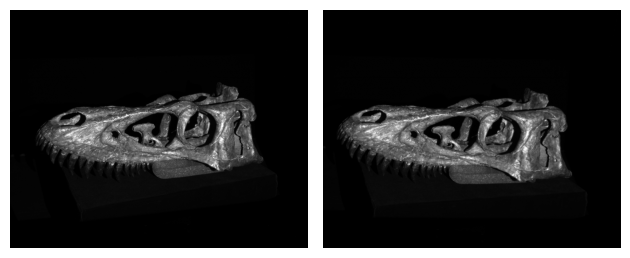

In [4]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im0, cmap="gray")
axes[0].axis('off')
axes[1].imshow(im0_rect, cmap="gray")
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Rectify all images
n_frames = 26
cam_0_ims1  = np.zeros((n_frames, size[1], size[0]))
cam_1_ims1  = np.zeros((n_frames, size[1], size[0]))
for i in range(n_frames):
    # Load and convert to grayscale
    img0 = (
        cv2.imread("casper/" +"sequence/frames0_%d.png" % i)
        .astype(float)
        .mean(2)
        / 255
    )
    img1 = (
        cv2.imread("casper/" + "sequence/frames1_%d.png" % i).astype(float).mean(2)
        / 255
    )
    cam_0_ims1 [i] = cv2.remap(img0, *maps0, cv2.INTER_LINEAR)
    cam_1_ims1 [i] = cv2.remap(img1, *maps1, cv2.INTER_LINEAR)

In [6]:
import re

def extract_number(filename):
    match = re.search(r"_(\d+)\.png$", filename)
    return int(match.group(1)) if match else 0


In [7]:
# folder_path = "casper/sequence/"
# # List is named such that cam_<number>_im_<fully on - 0 fully off - 1>
# cam_0_ims0 = []
# cam_0_ims1 = []
# for name in sorted(glob.glob(folder_path + "frames0*.png"), key=extract_number):
#     print(name)
#     image = cv2.imread(name).astype(float).mean(2) / 255
#     image_rect = cv2.remap(image, *maps0, cv2.INTER_LINEAR)
#     cam_0_ims0.append(image)
#     cam_0_ims1.append(image_rect)
# len(cam_0_ims0), len(cam_0_ims1)

In [8]:
# folder_path = "casper/sequence/"
# cam_1_ims0 = []
# cam_1_ims1 = []
# for name in sorted(glob.glob(folder_path + "frames1*.png"), key=extract_number):
#     print(name)
#     image = cv2.imread(name).astype(float).mean(2) / 255
#     image_rect = cv2.remap(image, *maps0, cv2.INTER_LINEAR)
#     cam_1_ims0.append(image)
#     cam_1_ims1.append(image_rect)
# len(cam_1_ims0), len(cam_1_ims1)

In [9]:
# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(cam_0_ims0[0], cmap="gray")
# axes[0].axis("off")
# axes[1].imshow(cam_0_ims1[0], cmap="gray")
# axes[1].axis("off")
# plt.tight_layout()
# plt.show()

In [10]:
# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(cam_1_ims0[0], cmap="gray")
# axes[0].axis("off")
# axes[1].imshow(cam_1_ims1[0], cmap="gray")
# axes[1].axis("off")
# plt.tight_layout()
# plt.show()

## Ex 13.3
At this point, we are ready to make a function that can compute the phases for each camera theta
= unwrap(ims). I suggest to write the code for camera 0 and to put it into a function once it’s working.
* Use indexing to get a list of the primary images out, and make sure it has length 16. 
* Put this list into the Fast Fourier Transform (np.fft.rfft) to find the Fourier spectrums of the primary images (fft_primary). We use rfft as the input is only real numbers. The function can operate on a list of arrays, which is ideal for our situation. Make sure to specify that the FFT should
operate along the first dimension of the array (axis=0). The Fourier component corresponding to the pattern is in the second component (fft_primary[1]).
* Get the phase of this using np.angle and call it theta_primary.
* Repeat the same steps for the secondary phase to obtain theta_secondary. * Compute the phase cue (theta_c) using the heterodyne principle.
* Find the order (o_primary) of the primary phase.
Use the order of the primary phase to obtain the unwrapped phase (theta).
Wrap all of the above into a function theta = unwrap(ims) and use it to obtain the phase for both cameras (theta0 and theta1)

2-17 are the 16 images in the primary pattern shifting. This pattern has 40 periods.
18-25 are the 8 images of the secondary pattern shifting. This pattern has 41 periods.

In [11]:
cam0_primary = cam_0_ims1[2: 18]
cam0_secondary = cam_0_ims1[18: 26]
cam1_primary = cam_1_ims1[2: 18]
cam1_secondary = cam_1_ims1[18: 26]
len(cam0_primary), len(cam1_primary)

(16, 16)

![unwrapping](images/unwrapping.png)

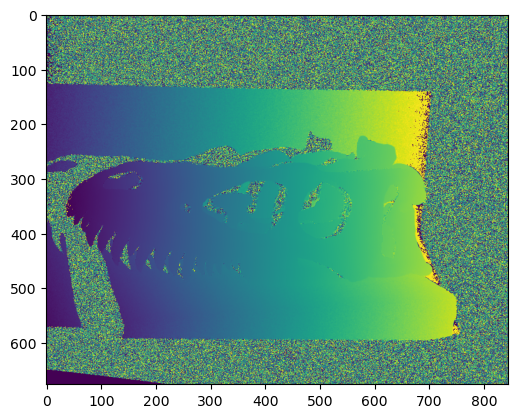

In [12]:
fft_primary = np.fft.rfft(cam0_primary, axis=0)
theta_primary = np.angle(fft_primary[1])
fft_secondary = np.fft.rfft(cam0_secondary, axis=0)
theta_secondary = np.angle(fft_secondary[1])
theta_c = (theta_secondary - theta_primary) % (2 * np.pi)
n_primary = 40
o_primary = (n_primary * theta_c - theta_primary) / (2 * np.pi)
theta_est = ((2 * np.pi * o_primary + theta_primary) / n_primary) % (2 * np.pi)
plt.imshow(theta_est)

In [13]:
def _unwrap(ims: np.array):
    """
        Given a list of images with indexes, 
        do an unwrap on phase-shift encoded images using phase cue and heterodyne principal for more robust estimation.
        2-17 are the 16 images in the primary pattern shifting. This pattern has 40 periods.
        18-25 are the 8 images of the secondary pattern shifting. This pattern has 41 periods.
        Args:
            ims (np.array): list of images
        Return:
            theta_est (np.array): estimate absolute phase value, which corresponds to a specific position in the projected pattern and thus the depth of the object.
    """
    cam_primary = ims[2: 18]
    cam_secondary = ims[18: 26]
    fft_primary = np.fft.rfft(cam_primary, axis=0)
    theta_primary = np.angle(fft_primary[1])
    fft_secondary = np.fft.rfft(cam_secondary, axis=0)
    theta_secondary = np.angle(fft_secondary[1])
    theta_c = (theta_secondary - theta_primary) % (2 * np.pi)
    n_primary = 40
    o_primary = (n_primary * theta_c - theta_primary) / (2 * np.pi)
    theta_est = ((2 * np.pi * o_primary + theta_primary) / n_primary) % (2 * np.pi)
    return theta_est

In [14]:
# Ex 13.3
def unwrap(imgs, n1):
    """
    Unwrap the measured phases. Adapter from Collister.

    Args:
        imgs (List[np.ndarray]): List of images from the cameras.
        n1 (int): Period of the primary pattern.

    Returns:
        theta_est (np.ndarray) : The phase of the primary pattern.
    """
    # Primary pattern
    primary_images = imgs[2:18]  # 16 images
    fft_primary = np.fft.rfft(primary_images, axis=0)
    fourier_primary = fft_primary[1]
    theta_primary = np.angle(fourier_primary)

    # Secondary pattern
    secondary_images = imgs[18:26]
    fft_secondary = np.fft.rfft(secondary_images, axis=0)
    fourier_secondary = fft_secondary[1]
    theta_secondary = np.angle(fourier_secondary)

    # Compute phase cue using heterodyne principle
    theta_c = np.mod(theta_secondary - theta_primary, 2 * np.pi)

    # Order of primary phase
    o_primary = np.rint((n1 * theta_c - theta_primary) / (2 * np.pi))

    # Estimate the phase
    theta_est = np.mod((2 * np.pi * o_primary + theta_primary) / n1, 2 * np.pi)
    return theta_est

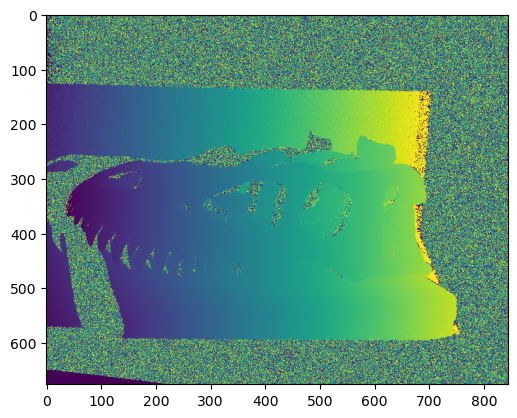

In [15]:
theta_est0 = unwrap(cam_0_ims1, 40)
plt.imshow(theta_est0)

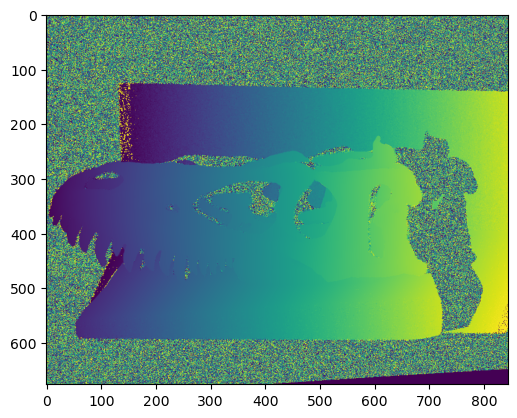

In [16]:
theta_est1 = unwrap(cam_1_ims1, 40)
plt.imshow(theta_est1)

## Ex 13.4
When inspecting the phase images theta0 and theta1 it is clear that not all pixels contain a valid measurement of the phase. This is because some pixels do not reflect enough light from the
projector to give a meaningful measurement. To fix this we introduce a binary mask that contains
3
the areas that are sufficiently illuminated by the projector. Subtract the fully on and fully off
projector image from each other (the first two elements of ims), to obtain a measurement of how
much projector light is in each pixel.

0 is an image fully illuminated by the projector (projector showing a white image)
1 is an image with the projector fully off

### Trying with cam0

In [17]:
diff0 = cam_0_ims1[0] - cam_0_ims1[1]
mask0 = (diff0 > (15 / 255)).astype(np.uint8)
mask0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(676, 844), dtype=uint8)

In [18]:
diff1 = cam_1_ims1[0] - cam_1_ims1[1]
mask1 = (diff1 > (15 / 255)).astype(np.uint8)
mask1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(676, 844), dtype=uint8)

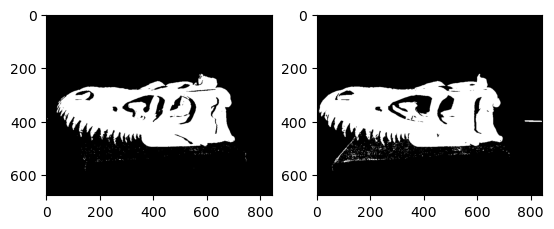

In [19]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(mask0, cmap="gray")
axes[1].imshow(mask1, cmap="gray")

## Ex 13.5
Now we need to find matches between the two cameras. As the images are rectified, we can constrain ourselves to search for a match on the  corresponding row in the other image.\
That is we need to create two lists (q0s and q1s) that contain the pixel coordinates of matches between camera 0 and 1.\
Use a double for-loop to iterate over all pixels in camera 0. For each valid pixel (mask0[i0,j0] = True which has the phase theta0[i0,j0]), we need to find the pixel in the other image that matches the best. \
As the images are rectified the epipolar line is a the row i0 in camera 1. Thus, we find the matching pixel in camera 1, selecting the pixel from row i0 which is valid mask1[i0,j1] = True and which has the closest phase match: theta0[i0,j0] ∼ theta1[i0,j1].\
Be aware that the points have to be of the form (x, y) i.e. [j, i], in order to work with our projection matrices.

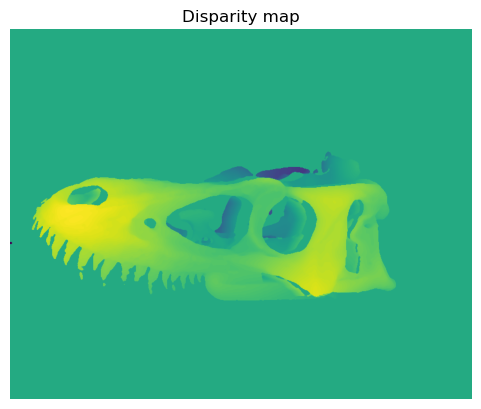

In [20]:
shape = mask0.shape
shape1 = mask1.shape
q0s = []
q1s = []
disparity = np.zeros_like(mask0, dtype=np.float32)  # Initialize with zeros

# Iterate over all pixels in camera 0
for i0 in range(shape[0]):
    point0 = (0, 0)
    point1 = (0, 0)
    for j0 in range(shape[1]):
        minDiff = 1000000
        if mask0[i0, j0]:  # valid pixel
            phase = theta_est0[i0][j0]
            epipolar_row = theta_est1[i0]  # row i0 in camera 1
            valid_epipolar_row = epipolar_row * mask1[i0]

            # closest phase match
            j1 = (np.abs(valid_epipolar_row - phase)).argmin()
            q0s.append([j0, i0])
            q1s.append([j1, i0])
            disparity[i0][j0] = j0 - j1

plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5))
plt.title("Disparity map")
plt.axis("off")
plt.show()

In [21]:
len(q0s), len(q1s)

(112671, 112671)

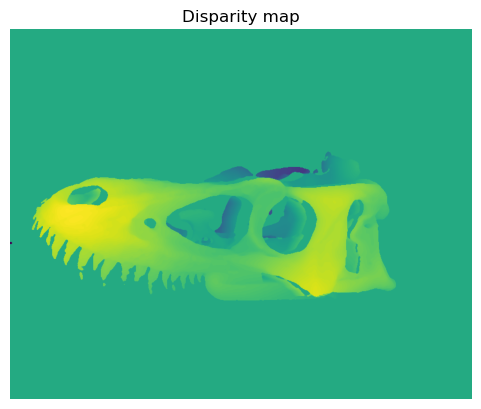

In [22]:
plt.imshow(cv2.medianBlur(disparity.astype(np.float32), 5))
plt.title("Disparity map")
plt.axis("off")
plt.show()

## Ex 13.6

In [23]:
import open3d as o3d

In [25]:
# Ex 13.6
# Triangulate the 3D points
projPoints0 = np.array(q0s).T.astype(np.float32)
projPoints1 = np.array(q1s).T.astype(np.float32)

Q = cv2.triangulatePoints(
    projMatr1=P0, projMatr2=P1, projPoints1=projPoints0, projPoints2=projPoints1
)
Q = Q[:-1] / Q[-1]  # convert to non-homogenous

# Remove negative z-coordinates that are behind the camera
Q_mask = np.where(Q[2] > 0, True, False)
Q_fixed = (Q.T[Q_mask]).T

# # Visualize 3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])